In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel("measurements2.xlsx")
data

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
383,16.0,3.7,39,24.5,18,NaN,SP98,0,0,0,NaN,NaN
384,16.1,4.3,38,25.0,31,AC,SP98,1,0,0,NaN,NaN
385,16.0,3.8,45,25.0,19,NaN,SP98,0,0,0,NaN,NaN
386,15.4,4.6,42,25.0,31,AC,SP98,1,0,0,NaN,NaN


In [3]:
# In a first view, I see the E10 consume a little bit more than SP98
print(data.groupby(by='gas_type')['consume'].mean().round(2))

gas_type
E10     4.93
SP98    4.90
Name: consume, dtype: float64


In [4]:
# AC, rain and sum are boleean columns so I need to change it to object
data.dtypes

distance         float64
consume          float64
speed              int64
temp_inside      float64
temp_outside       int64
specials          object
gas_type          object
AC                 int64
rain               int64
sun                int64
refill liters    float64
refill gas        object
dtype: object

In [5]:
data[['AC', 'rain', 'sun']] = data[['AC', 'rain', 'sun']].astype(object)

In [6]:
# I will check the NaN values first. I will need to fill them or drop them.
data.isna().sum()

distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64

In [7]:
# First I will work with temp_inside Nan values 
data['temp_inside'].unique()

array([21.5, 22.5, 20. ,  nan, 21. , 20.5, 23. , 23.5, 25. , 24. , 22. ,
       19. , 24.5, 25.5])

In [8]:
data['temp_inside'].describe()

count    376.000000
mean      21.929521
std        1.010455
min       19.000000
25%       21.500000
50%       22.000000
75%       22.500000
max       25.500000
Name: temp_inside, dtype: float64

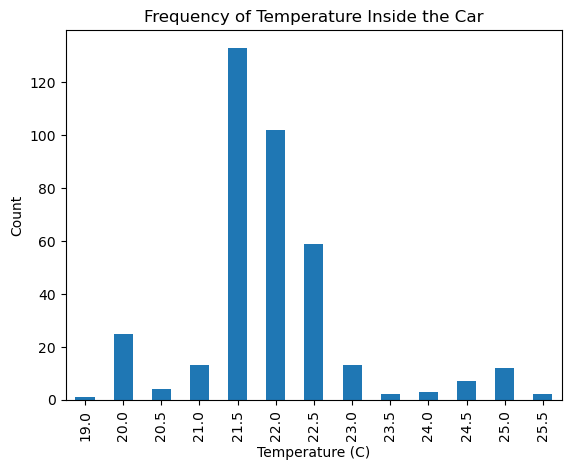

In [9]:
# Compute frequency counts of 'temp_inside' column
temp_counts = data['temp_inside'].value_counts().sort_index()

# Create bar plot of frequency counts
temp_counts.plot(kind='bar')

# Add axis labels and title
plt.xlabel('Temperature (C)')
plt.ylabel('Count')
plt.title('Frequency of Temperature Inside the Car')

# Display the plot
plt.show()

In [10]:
# I will fill with the median dispite the mean is 21.92 and the most common value is 21.5 Because I think will make more sense for the prediction model
data['temp_inside'] = data['temp_inside'].fillna(22)

In [11]:
# I will go now with the Nan values of specials
data['specials'].unique()

array([nan, 'AC rain', 'AC', 'rain', 'snow', 'AC snow',
       'half rain half sun', 'sun', 'AC sun', 'sun ac', 'ac', 'AC Sun',
       'ac rain'], dtype=object)

In [12]:
# Create new column 'snow'
data['snow'] = np.where((data['specials'] == 'snow') | (data['specials'] == 'AC snow'), 1, 0)
# Drop column specials because is not giving me new information now
data = data.drop(['specials'], axis=1)

In [13]:
# I will drop refill gas column because is giving me the same information as gas_type and refill_litter because is not giving me relevant information
data = data.drop(['refill gas', 'refill liters'], axis=1)

In [14]:
data['real consume'] = round((data['consume'] * data['distance'])/100,2)

In [15]:
data['km_absolute'] = data['distance'].cumsum()

Text(32.87673611111112, 0.5, 'consume [l/100km]')

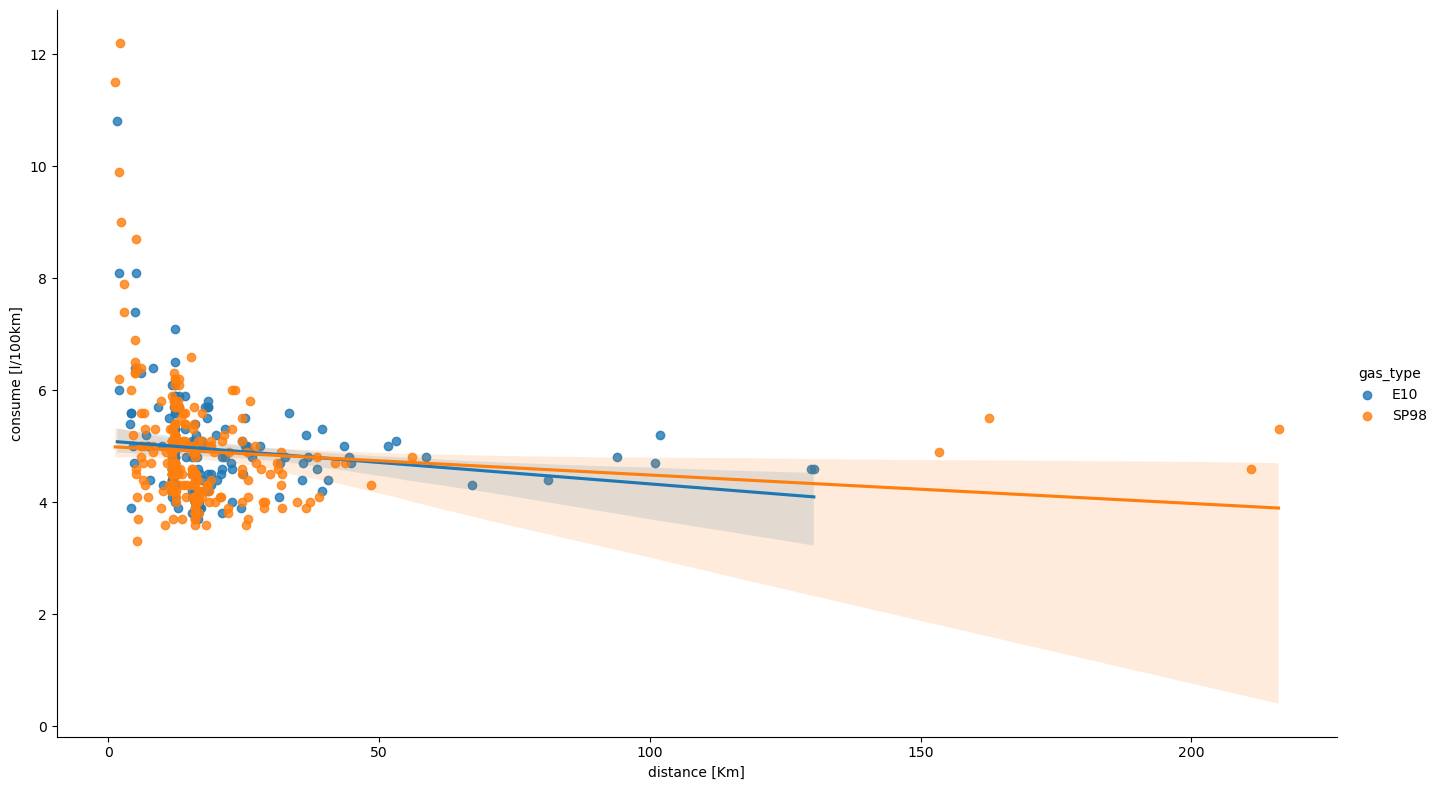

In [16]:
#Consume vs Km_absolute
sns.lmplot(data = data, x = 'distance', y = 'consume', hue = 'gas_type', height=8,aspect=1.7)
plt.xlabel('distance [Km]')
plt.ylabel('consume [l/100km]')
# For biggest distances E10 is consuming less than SP98

Text(32.87673611111112, 0.5, 'consume [l/100km]')

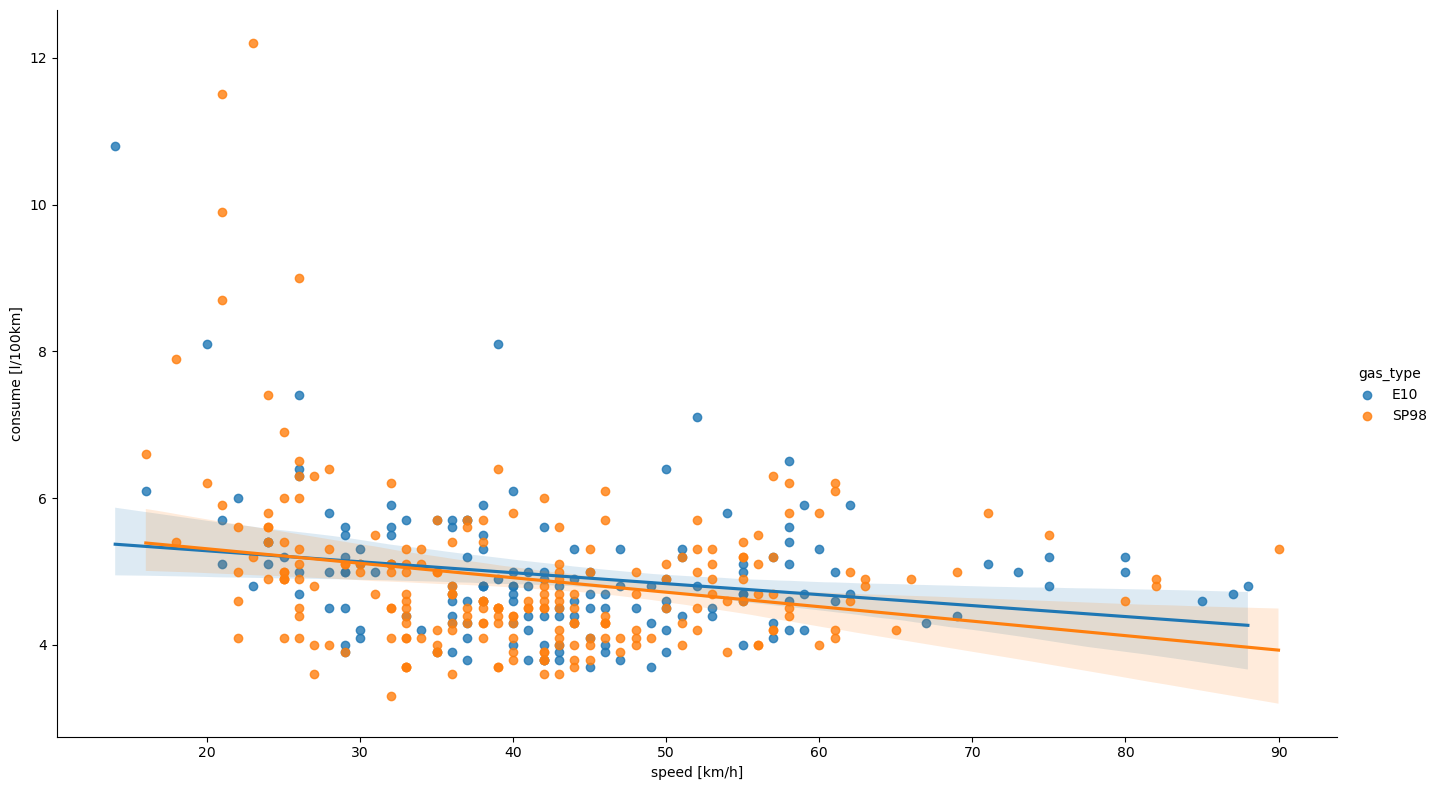

In [17]:
# Speed vs consume
sns.lmplot(data=data, x = 'speed',y =  'consume',hue = 'gas_type', height=8, aspect=1.7)
plt.xlabel('speed [km/h]')
plt.ylabel('consume [l/100km]')
# At higher Speed SP98 is consuming less than E10

Text(32.87673611111112, 0.5, 'consume [l/100km]')

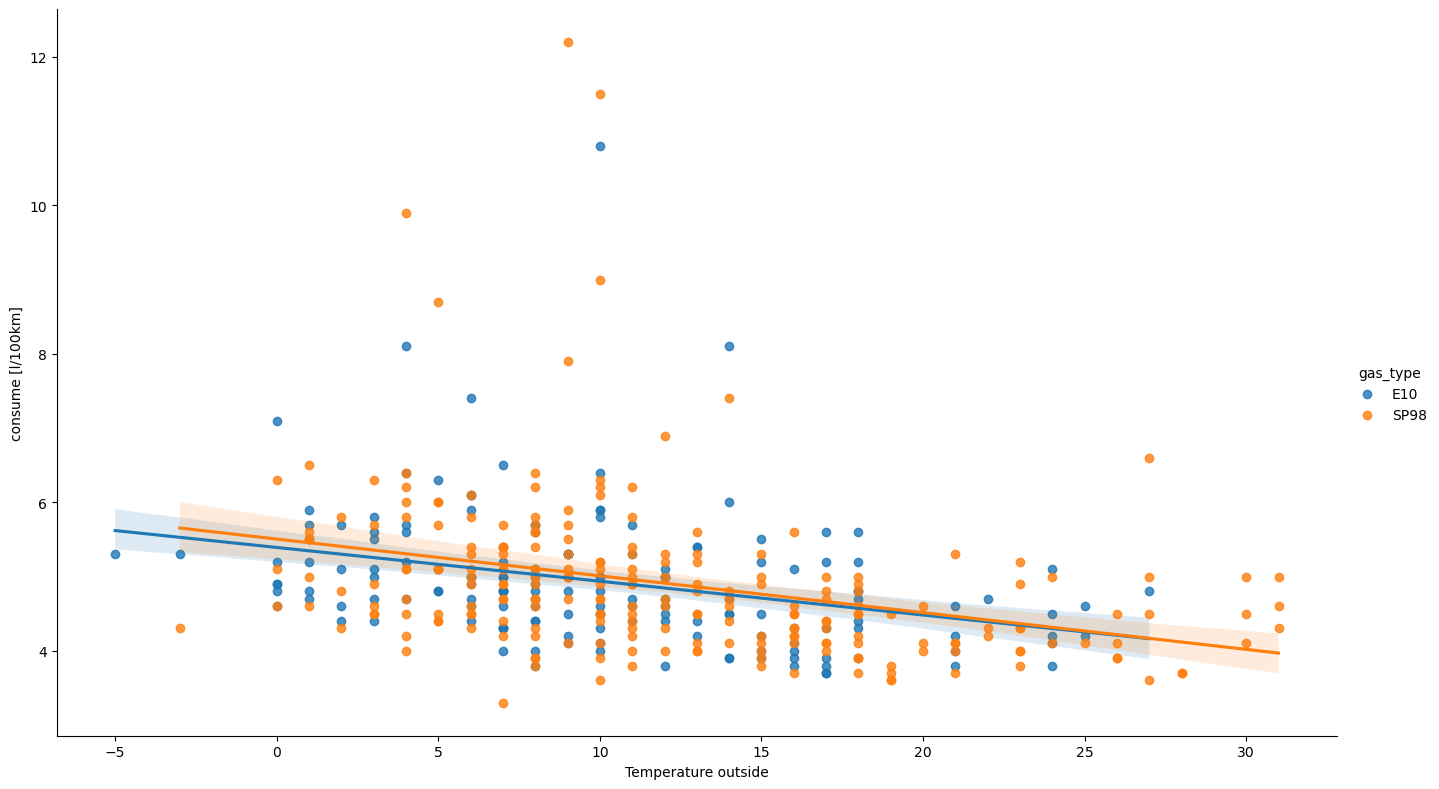

In [19]:
# temp_outside vs consume
sns.lmplot(data=data, x = 'temp_outside',y =  'consume',hue = 'gas_type', height=8, aspect=1.7)
plt.xlabel('Temperature outside')
plt.ylabel('consume [l/100km]')
# there is no difference related with the temperature outside

In [ ]:
# I will start to prepare for the model. First, I will check if there is correlation between columns
corr_matrix = data.corr()
# Plot heatmap
sns.heatmap(corr_matrix, annot=True)

In [ ]:
# I will try with the Linear regressor.
def preparing_data_to_model(data, random_state=None):   
    y = data['consume']
    X = data.drop(['consume','real consume'], axis=1)
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Numericals
    X_train_num = X_train.select_dtypes(include=np.number)
    X_test_num = X_test.select_dtypes(include=np.number)

    # Categoricals
    X_train_cat = X_train.select_dtypes(include='object')
    X_test_cat = X_test.select_dtypes(include='object')
    from sklearn.preprocessing import StandardScaler

    # Initialize the StandardScaler object
    scaler = StandardScaler()

    # Fit and transform the scaler on the numerical train features
    X_train_num_scaled = scaler.fit_transform(X_train_num)

    # Transform the scaler on the numerical test features
    X_test_num_scaled = scaler.transform(X_test_num)
    from sklearn.preprocessing import OneHotEncoder

    # Create the OneHotEncoder object
    encoder = OneHotEncoder(drop='first')

    # Fit and transform the encoder on the training categorical columns
    train_encoded = encoder.fit_transform(X_train_cat)

    # Transform the encoder on the testing categorical columns
    test_encoded = encoder.transform(X_test_cat)

    # Get the names of the encoded features
    feature_names = encoder.get_feature_names_out(X_train_cat.columns)

    # Convert the encoded array back into dataframes with the feature names
    X_train_cat_encoded = pd.DataFrame(train_encoded.toarray(), columns=feature_names)
    X_test_cat_encoded = pd.DataFrame(test_encoded.toarray(), columns=feature_names)
    
    # combine the scaled numerical features and the categorical encoded features of the training data
    train_processed = pd.concat([pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns), X_train_cat_encoded.reset_index(drop=True)], axis=1)
    
    # Combine the numerical and categorical features back into a single dataframe for the test data
    test_processed = pd.concat([pd.DataFrame(X_test_num_scaled, columns=X_train_num.columns), X_test_cat_encoded], axis=1)
    
    return train_processed, test_processed, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = preparing_data_to_model(data, random_state=None)

In [ ]:
from sklearn.linear_model import LinearRegression
# fit a linear regression model to the training data
model = LinearRegression().fit(x_train, y_train)

# predict the y-values for the testing data
y_pred = model.predict(x_test)

In [ ]:
# Evaluate the model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate the model performance
mse = round(mean_squared_error(y_test, y_pred),2)
mae = round(mean_absolute_error(y_test, y_pred),2)
rmse = round(np.sqrt(mse),2)
r2 = round(r2_score(y_test, y_pred),2)

print("R-squared:", r2)
print("Mean squared error:", mse)
print("Root mean squared error:", rmse)
print("Mean absolute error:", mae)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# create a random forest regressor object and fit it
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(x_train, y_train)

# predict the y-values for the testing data
y_pred1 = rf.predict(x_test)

In [ ]:
# Evaluate the model performance
mse1 = round(mean_squared_error(y_test, y_pred1),2)
mae1 = round(mean_absolute_error(y_test, y_pred1),2)
rmse1 = round(np.sqrt(mse1),2)
r2_1 = round(r2_score(y_test, y_pred1),2)

print("R-squared:", r2_1)
print("Mean squared error:", mse1)
print("Root mean squared error:", rmse1)
print("Mean absolute error:", mae1)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# create a random decisiontree regressor object and fit it
dt=DecisionTreeRegressor(criterion='squared_error',splitter='best',max_depth=3,random_state=42).fit(x_train,y_train)

# predict the y-values for the testing data
y_pred2=dt.predict(x_test)

In [ ]:
# Evaluate the model performance
mse2 = round(mean_squared_error(y_test, y_pred2),2)
mae2 = round(mean_absolute_error(y_test, y_pred2),2)
rmse2 = round(np.sqrt(mse2),2)
r2_2 = round(r2_score(y_test, y_pred2),2)

print("R-squared:", r2_2)
print("Mean squared error:", mse2)
print("Root mean squared error:", rmse2)
print("Mean absolute error:", mae2)

I get best score with the Random Forest regressor which have a R2 of 0.5 and Mse of 0.45. To sum up, I can see in the data visualitaion that the mean consumption is higher for the E10 (4.93) dispite the SP98 (4.90). There are some factors making the difference like the distance (if you make small rides wiht SP98 consume less). Other example is the speed because at high speed the consume is lower with SP98.